# Предсказание температуры расплава стали


Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру расплава стали.

Метрика качества модели MAE. Необходимо достичь MAE не более 6,0.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### План исследования

1. [Исследовательский анализ данных.](#section1)
    * [Данные о температуре](#section1.1)
    * [Данные об электродах](#section1.2)
    * [Данные о подаче сыпучих материалов](#section1.3)
    * [Данные о проволочных материалах](#section1.4)
    * [Данные о продувке сплава газом](#section1.5)
    
    
2. [Сбор датасета.](#section2)
3. [Обучение моделей.](#section3)
4. [Тестирование моделей.](#section4)
5. [Выводы.](#section5)


<a id='section1'> </a>

## Исследовательский анализ даных

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.dummy import DummyRegressor
from tqdm.notebook import tqdm
from catboost import Pool, cv, CatBoostRegressor

In [2]:
DATA_DIR = './datasets/final_steel/'

<a id='section1.1'> </a>
### Данные о температуре

In [3]:
data_temp = pd.read_csv(DATA_DIR + 'data_temp.csv')
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [4]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Данные содержат пропуски в столбце "температура". Необходимо преобразовать данные в столбце "время замера" к типу datetime. 
Поскольку температура в данной задаче является целевым признаком, то строки в которых значение температуры не указано просто удалим.

In [5]:
data_temp = data_temp.dropna()

# провверим что не осталось незаполненных строк
data_temp['Температура'].isna().sum()

0

In [6]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13006 non-null  int64         
 1   Время замера  13006 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 406.4 KB


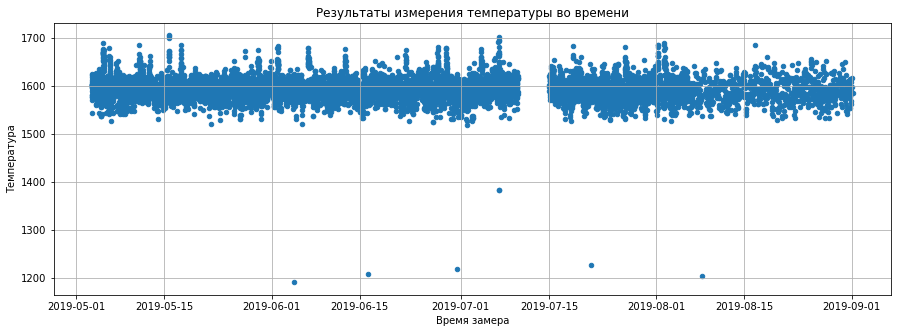

In [7]:
(data_temp.plot(x='Время замера', y='Температура', kind='scatter', figsize=(15, 5), grid=True)
          .set(title='Результаты измерения температуры во времени'));

In [8]:
data_temp.describe()

,key,Температура
count,13006.000000,13006.000000
mean,1328.447793,1591.840920
std,804.740001,21.375851
min,1.000000,1191.000000
25%,638.000000,1581.000000
50%,1315.000000,1591.000000
75%,1977.750000,1601.000000
max,3241.000000,1705.000000


На графике явно видны отдельные измерения "вываливающиеся" из общей картины. Видны пропущенные значения между 8 и 15 июля 2019 года. Так же есть подозрение что параметры распределения температуры после 7 августа 2019 г отличаются от тех что были до этой даты. Посмотрим на гистограмму температуры.

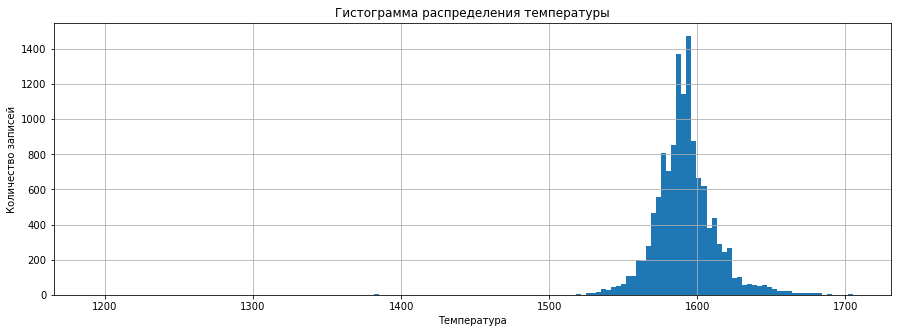

In [9]:
(data_temp['Температура'].hist(bins=151,figsize=(15, 5))
                         .set(title='Гистограмма распределения температуры',
                              xlabel='Температура',
                              ylabel='Количество записей'));

Видно, что основная часть измерений сосредоточена в диапазоне от 1500 до 1700 градусов. Оценим количество записей в которых температура менее 1500 градусов

In [10]:
(data_temp['Температура'] < 1500).sum()

7

Так как количество записей не велико. обнаруженные выбросы удалим и построим гистограмму еще раз

In [11]:
data_temp = data_temp.drop(data_temp[data_temp['Температура'] < 1500].index, axis='index')
# проверим что удаление произошло как задумано
(data_temp['Температура'] < 1500).sum()

0

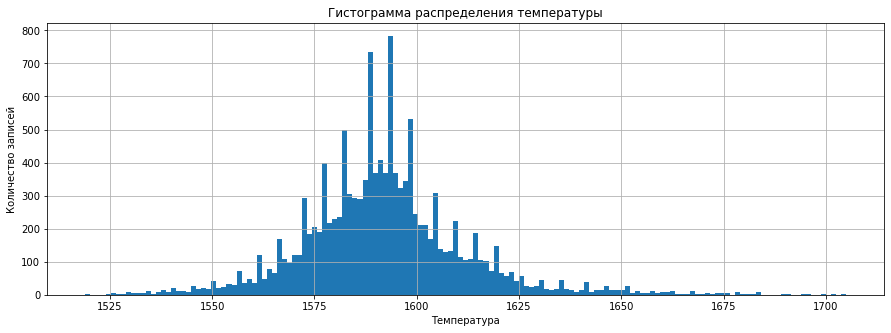

In [12]:
(data_temp['Температура'].hist(bins=151, figsize=(15, 5))
                         .set(title='Гистограмма распределения температуры',
                              xlabel='Температура',
                              ylabel='Количество записей'));

На гистограмме видна "линейчатость". Фактически можно представить что данные сгенерированы из суммы двух распределений: нормального и распеделия которое принимает определенные дискретные значения.

Теперь проверим предположение о том что распределения температуры до 7 августа 2019 г и после разные. Построим соответствующие гистограммы.

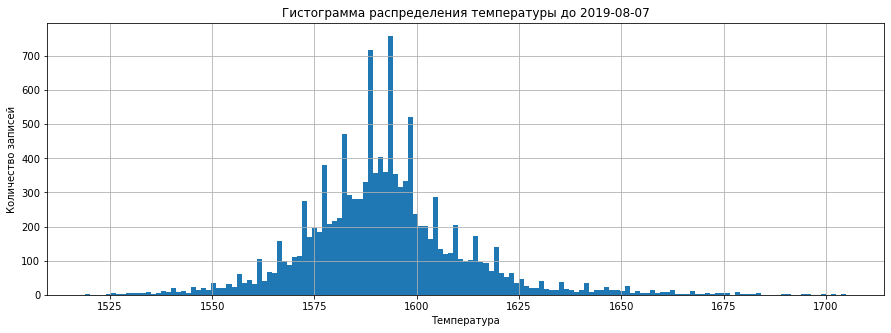

In [13]:
(data_temp.sort_values('Время замера').set_index('Время замера')[:'2019-08-07']['Температура']
          .hist(bins=151, figsize=(15, 5))
          .set(title='Гистограмма распределения температуры до 2019-08-07',
               xlabel='Температура',
               ylabel='Количество записей'));

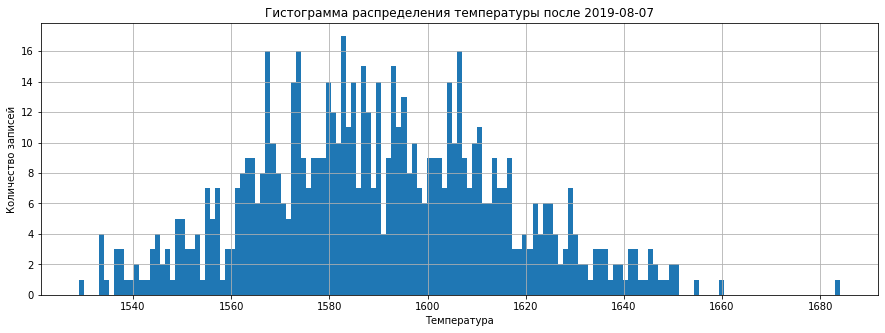

In [14]:
(data_temp.sort_values('Время замера').set_index('Время замера')['2019-08-07':]['Температура']
          .hist(bins=151, figsize=(15, 5))
          .set(title='Гистограмма распределения температуры после 2019-08-07',
               xlabel='Температура',
               ylabel='Количество записей'));

Распределение температуры после 7 августа 2019 года действительно несколько отличается от более раннего распределения. Отсутствует ярко выраженная "линейчатость" на графике.

Сформируем датарейм сгруппированный по партиям и посметрим на распределения температур от партий.

In [15]:
temp_groupby_key = data_temp.groupby('key')['Температура'].agg(['count', 'median', 'mean', 'std', 'first', 'last'])
temp_groupby_key.head(10)

,count,median,mean,std,first,last
key,,,,,,
1,5,1604.0,1601.400000,18.311199,1571.0,1613.0
2,6,1595.5,1593.500000,12.973049,1581.0,1602.0
3,5,1598.0,1597.800000,1.303840,1596.0,1599.0
4,3,1623.0,1616.333333,13.316656,1601.0,1625.0
5,2,1589.0,1589.000000,18.384776,1576.0,1602.0
6,5,1596.0,1584.000000,24.217762,1543.0,1596.0
7,5,1595.0,1592.200000,7.791020,1586.0,1599.0
8,4,1599.0,1594.750000,12.093387,1577.0,1598.0
9,5,1589.0,1590.800000,3.898718,1587.0,1592.0


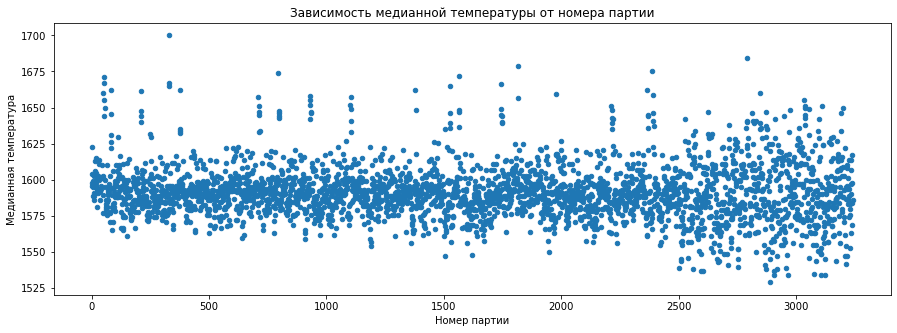

In [16]:
(temp_groupby_key.reset_index().plot(x='key', y='median', kind='scatter', figsize=(15, 5))
          .set(title='Зависимость медианной температуры от номера партии',
               xlabel='Номер партии',
               ylabel='Медианная температура'));

После 2500 партии разброс медианной температуры от партии к партии увеличивается. Возможно с этого времени завод расширил номенклатуру изготавливаемоей продукции или заменил оборудование. Посмотрим на распределение медианной температуры по партиям.

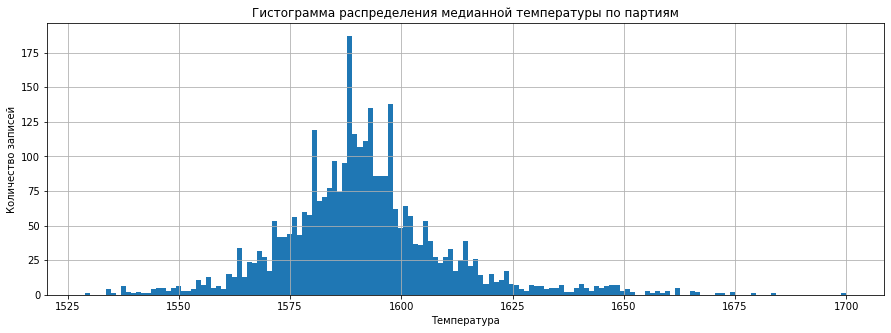

In [17]:
(temp_groupby_key['median'].hist(bins=151, figsize=(15, 5))
          .set(title='Гистограмма распределения медианной температуры по партиям',
               xlabel='Температура',
               ylabel='Количество записей'));

In [18]:
temp_groupby_key['median'].describe()

count    3215.000000
mean     1591.577294
std        18.615284
min      1529.000000
25%      1581.000000
50%      1590.500000
75%      1599.000000
max      1700.000000
Name: median, dtype: float64

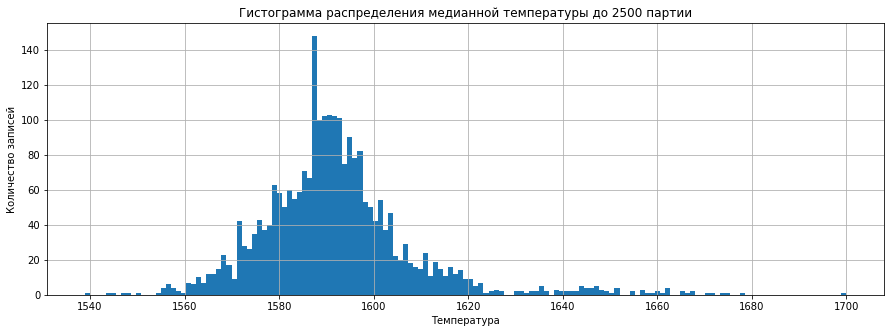

In [19]:
(temp_groupby_key[:2500]['median'].hist(bins=151, figsize=(15, 5))
          .set(title='Гистограмма распределения медианной температуры до 2500 партии',
               xlabel='Температура',
               ylabel='Количество записей'));

In [20]:
temp_groupby_key[:2500]['median'].describe()

count    2500.000000
mean     1591.958000
std        16.271083
min      1539.000000
25%      1583.000000
50%      1590.500000
75%      1598.000000
max      1700.000000
Name: median, dtype: float64

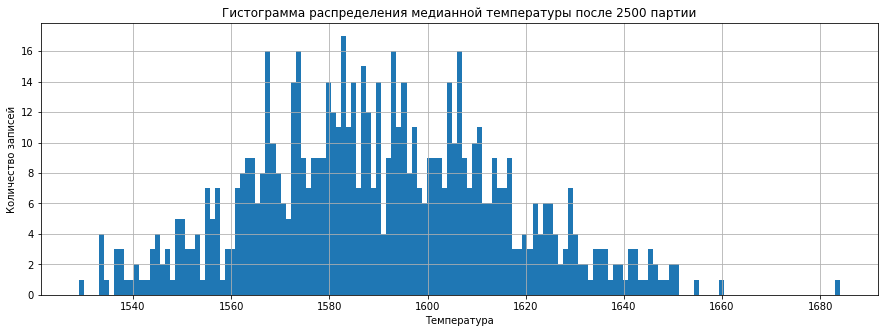

In [21]:
(temp_groupby_key[2500:]['median'].hist(bins=151, figsize=(15, 5))
          .set(title='Гистограмма распределения медианной температуры после 2500 партии',
               xlabel='Температура',
               ylabel='Количество записей'));

In [22]:
temp_groupby_key[2500:]['median'].describe()

count     715.000000
mean     1590.246154
std        25.119007
min      1529.000000
25%      1573.000000
50%      1589.000000
75%      1607.000000
max      1684.000000
Name: median, dtype: float64

СКО медианной температуры до 2500 партии примерно в 1,5 раза меньше аналогичного СКО после 2500 (16 градусов против 25 градусов). Возможно это нужно будет учесть при построении модели. Так же посмотрим на распределения первой и последней температуры для партии.

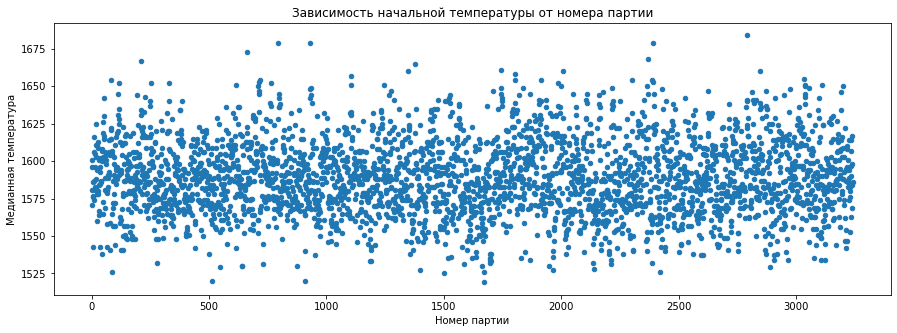

In [23]:
(temp_groupby_key.reset_index().plot(x='key', y='first', kind='scatter', figsize=(15, 5))
          .set(title='Зависимость начальной температуры от номера партии',
               xlabel='Номер партии',
               ylabel='Медианная температура'));

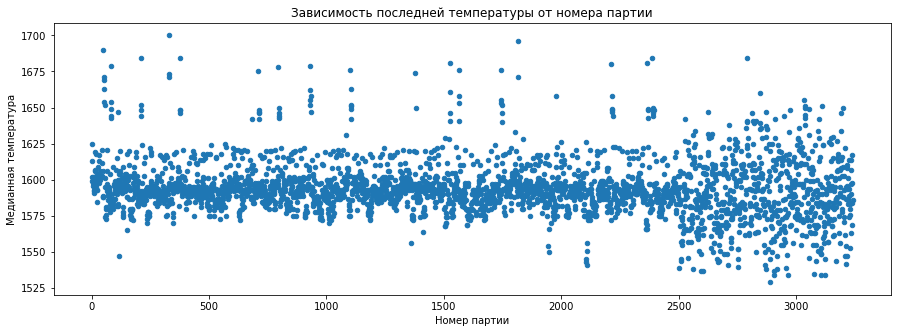

In [24]:
(temp_groupby_key.reset_index().plot(x='key', y='last', kind='scatter', figsize=(15, 5))
          .set(title='Зависимость последней температуры от номера партии',
               xlabel='Номер партии',
               ylabel='Медианная температура'));

Для последней температуры изменение распределения после 2500 партии еще более явное. Посмотрим на распределения последней температуры до 2500 партии и после

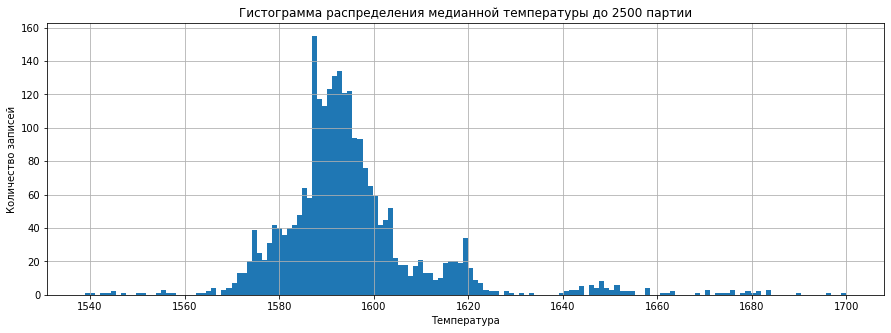

In [25]:
(temp_groupby_key[:2500]['last'].hist(bins=151, figsize=(15, 5))
          .set(title='Гистограмма распределения медианной температуры до 2500 партии',
               xlabel='Температура',
               ylabel='Количество записей'));

In [26]:
temp_groupby_key[:2500]['last'].describe()

count    2500.000000
mean     1595.137600
std        16.177594
min      1539.000000
25%      1587.000000
50%      1593.000000
75%      1599.000000
max      1700.000000
Name: last, dtype: float64

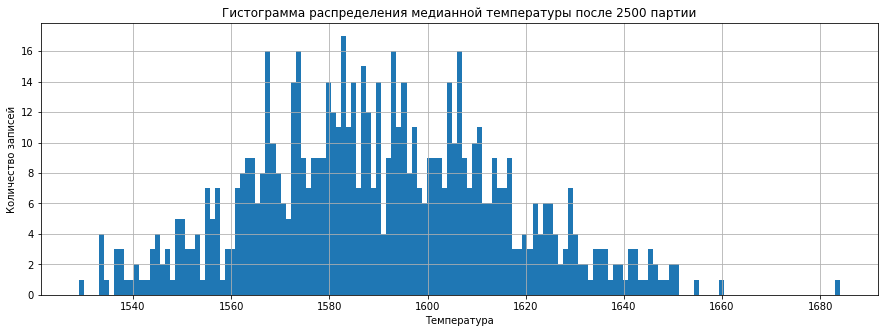

In [27]:
(temp_groupby_key[2500:]['last'].hist(bins=151, figsize=(15, 5))
          .set(title='Гистограмма распределения медианной температуры после 2500 партии',
               xlabel='Температура',
               ylabel='Количество записей'));

In [28]:
temp_groupby_key[2500:]['last'].describe()

count     715.000000
mean     1590.246154
std        25.119007
min      1529.000000
25%      1573.000000
50%      1589.000000
75%      1607.000000
max      1684.000000
Name: last, dtype: float64

Для последней температуры наблюдаются те же тенденции что и для медианной температуры. До 2500 партии распределение достаточно компактное, а после 2500 партии дисперсия распределения возрастает. Для начальной температуры данное поведение не характерно.

Посмотрим на сгруппированный датафрейм еще раз.

In [29]:
temp_groupby_key

,count,median,mean,std,first,last
key,,,,,,
1,5,1604.0,1601.400000,18.311199,1571.0,1613.0
2,6,1595.5,1593.500000,12.973049,1581.0,1602.0
3,5,1598.0,1597.800000,1.303840,1596.0,1599.0
4,3,1623.0,1616.333333,13.316656,1601.0,1625.0
5,2,1589.0,1589.000000,18.384776,1576.0,1602.0
...,...,...,...,...,...,...
3237,1,1569.0,1569.000000,NaN,1569.0,1569.0
3238,1,1584.0,1584.000000,NaN,1584.0,1584.0
3239,1,1598.0,1598.000000,NaN,1598.0,1598.0


Поcкольку в качестве целевого признака выступает последняя измеренная температура для соответствующей партии, то необходимо потребовать чтобы для каждой партии было не менее двух измерений. Если измерение всего одно, то первая и последняя температуры будут совпадать. Удалим из датафрейма партии для которых число измерений температуры меньше двух.

In [30]:
temp_groupby_key = temp_groupby_key.drop(temp_groupby_key[temp_groupby_key['count']<2].index, axis='index')
temp_groupby_key

,count,median,mean,std,first,last
key,,,,,,
1,5,1604.0,1601.400000,18.311199,1571.0,1613.0
2,6,1595.5,1593.500000,12.973049,1581.0,1602.0
3,5,1598.0,1597.800000,1.303840,1596.0,1599.0
4,3,1623.0,1616.333333,13.316656,1601.0,1625.0
5,2,1589.0,1589.000000,18.384776,1576.0,1602.0
...,...,...,...,...,...,...
2495,3,1590.0,1583.666667,11.846237,1570.0,1591.0
2496,4,1583.5,1579.000000,18.565200,1554.0,1591.0
2497,2,1580.0,1580.000000,12.727922,1571.0,1589.0


<a id='section1.2'> </a>

### Данные об электродах

In [31]:
data_arc = pd.read_csv(DATA_DIR + 'data_arc.csv')
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [32]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Пропусков в данной таблице нет. Преобразуем столбцы "Начало нагрева дугой" и "Конец нагрева дугой" к типу datetime. Дополнительно создадим в даных столбец "Время нагрева".

In [33]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])
data_arc['Время нагрева, c'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds

In [34]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
 5   Время нагрева, c      14876 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 697.4 KB


In [35]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,"Время нагрева, c"
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148


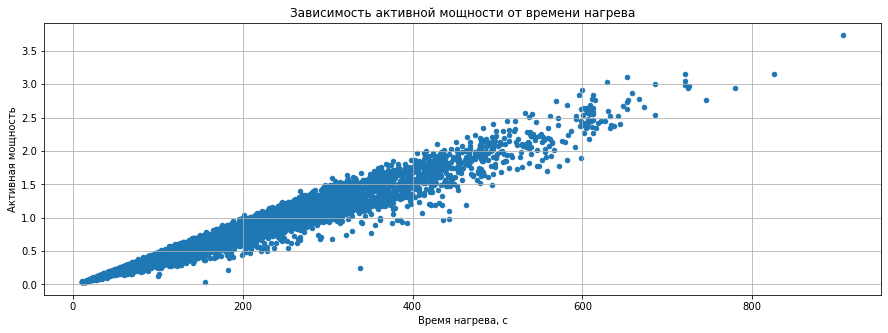

In [36]:
(data_arc.plot(x='Время нагрева, c', y='Активная мощность', kind='scatter', figsize=(15, 5), grid=True)
          .set(title='Зависимость активной мощности от времени нагрева'));

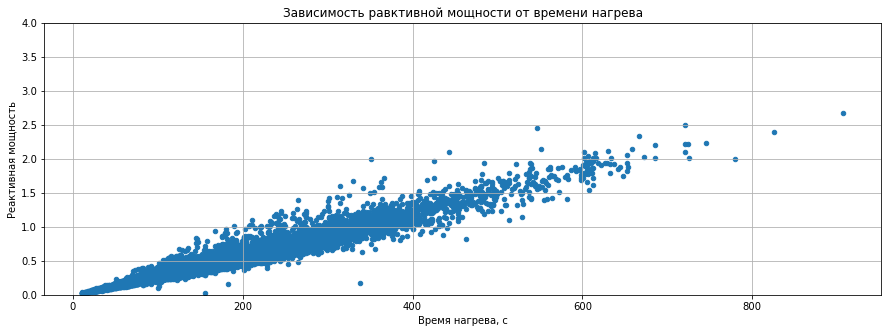

In [37]:
(data_arc.plot(x='Время нагрева, c', y='Реактивная мощность', kind='scatter', figsize=(15, 5), grid=True, ylim=(0, 4))
          .set(title='Зависимость равктивной мощности от времени нагрева'));

Как активная так и реактивная мощность сильно коррелируют с длительностью нагрева. Интересно, что с увеличением времени нагрева так же возрастает и разброс мощностей. График реактивной мощности ограничен по оси y, при этом там есть выброс с сильноотрицательным значением реактивной мощности

In [38]:
data_arc[data_arc['Реактивная мощность']<0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,"Время нагрева, c"
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924,109


Заменим реактивную мощность в этой строчке на медианную для данного времени нагрева.

In [39]:
data_arc.loc[(data_arc['key']==2116).index, 'Реактивная мощность'] = \
data_arc[data_arc['Время нагрева, c']==109]['Реактивная мощность'].median()

In [40]:
# проверим что больше не осталось строчек со значением мощности меньше нуля
data_arc[data_arc['Реактивная мощность']<0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,"Время нагрева, c"


Сгруппируем данные по партиям

In [41]:
arc_groupby_key = data_arc.groupby('key').agg({'Активная мощность': ['count', 'median', 'sum'],
                                               'Реактивная мощность': ['sum'],
                                               'Время нагрева, c': ['median', 'sum'], 
                                              })
arc_groupby_key.head(10)

Активная мощность                     Реактивная мощность  \
                count    median       sum                 sum   
key                                                             
1                   5  0.805607  4.878147            1.571799   
2                   4  0.659060  3.052598            1.257439   
3                   5  0.429355  2.525882            1.571799   
4                   4  0.781301  3.209250            1.257439   
5                   4  0.729026  3.347173            1.257439   
6                   4  0.983947  3.955108            1.257439   
7                   4  0.382923  2.547375            1.257439   
8                   4  0.883135  3.762755            1.257439   
9                   5  0.509361  2.081951            1.571799   
10                  6  0.429052  2.923622            1.886159   

    Время нагрева, c        
              median   sum  
key                         
1              185.0  1098  
2              173.5   811  
3              109.0   655  
4              182.0   741  
5              191.5   869  
6              225.5   952  
7              108.5   673  
8              205.5   913  
9              156.0   625  
10             117.0   825

Посмотрим на распределения мощностей по партиям.

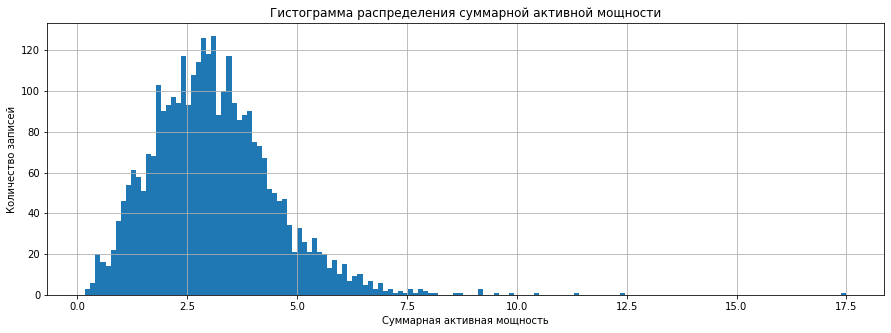

In [42]:
(arc_groupby_key[('Активная мощность', 'sum')].hist(bins=151, figsize=(15, 5))
          .set(title='Гистограмма распределения суммарной активной мощности',
               xlabel='Суммарная активная мощность',
               ylabel='Количество записей'));

In [43]:
arc_groupby_key[('Активная мощность', 'sum')].describe()

count    3214.000000
mean        3.103138
std         1.397390
min         0.186226
25%         2.126339
50%         2.990537
75%         3.901147
max        17.496497
Name: (Активная мощность, sum), dtype: float64

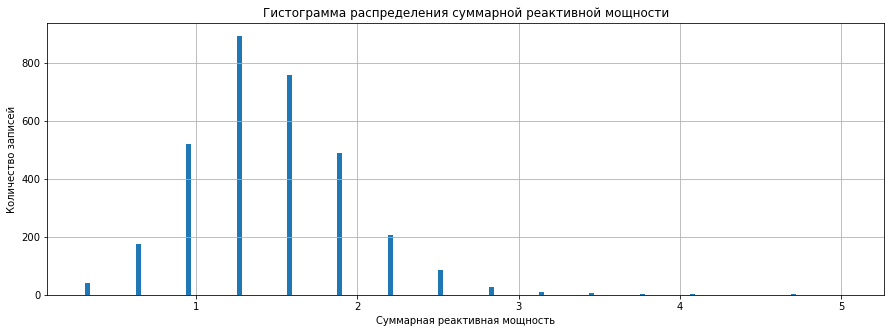

In [44]:
(arc_groupby_key[('Реактивная мощность', 'sum')].hist(bins=151, figsize=(15, 5))
          .set(title='Гистограмма распределения суммарной реактивной мощности',
               xlabel='Суммарная реактивная мощность',
               ylabel='Количество записей'));

Распределение суммарной реактивной мощности имеет ярковыраженный линейчатый характер, что, возможно, частично соответствует линейчати распределения температур.

<a id='section1.3'> </a>

### Данные о подаче сыпучих материалов

In [45]:
data_bulk_time = pd.read_csv(DATA_DIR + 'data_bulk_time.csv')
data_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


In [46]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [47]:
data_bulk = pd.read_csv(DATA_DIR + 'data_bulk.csv')
data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [48]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


В таблице data_bulk приведен объем добавляемых сыпучих материалов, а в таблице data_bulk_time - время их добавления. В таблицах много пропущенных значений из-за того, что для каждой партии существует свой ограниченный набор добавляемых компонент, а остальные материалы в смесь не добавляются. Посмотрим на распределения.

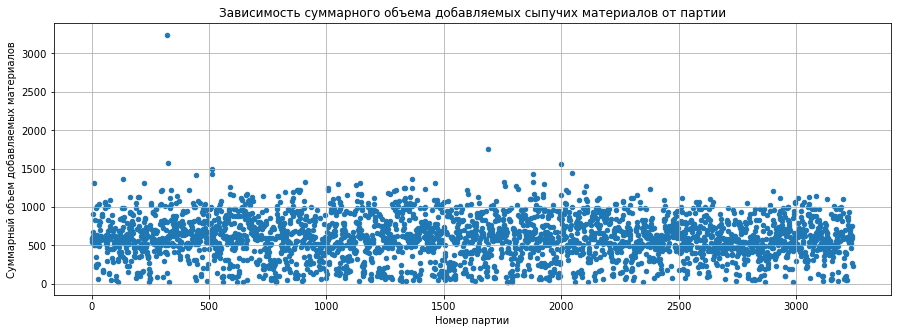

In [49]:
(data_bulk.set_index('key').sum(axis=1, skipna=True).to_frame('bulk_sum').reset_index()
 .plot(x='key', y='bulk_sum', kind='scatter', figsize=(15, 5), grid=True)
 .set(title='Зависимость суммарного объема добавляемых сыпучих материалов от партии',
     xlabel='Номер партии',
     ylabel='Суммарный объем добавляемых материалов'));

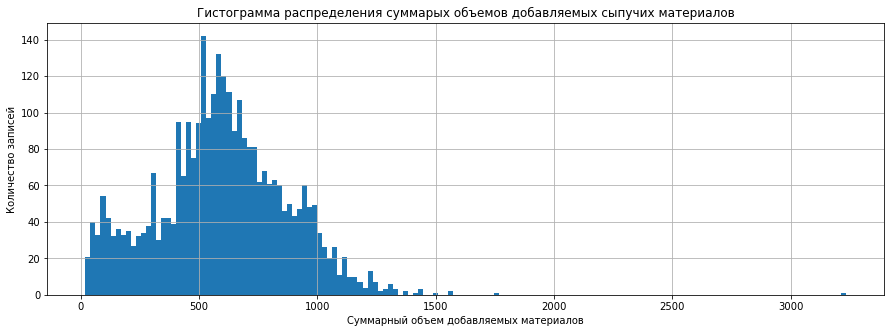

In [50]:
(data_bulk.set_index('key').sum(axis=1, skipna=True).hist(bins=151, figsize=(15, 5))
          .set(title='Гистограмма распределения суммарых объемов добавляемых сыпучих материалов',
               xlabel='Суммарный объем добавляемых материалов',
               ylabel='Количество записей'));

In [51]:
data_bulk.set_index('key').sum(axis=1, skipna=True).describe()

count    3129.000000
mean      595.503356
std       276.557794
min        19.000000
25%       429.000000
50%       591.000000
75%       772.000000
max      3235.000000
dtype: float64

Лишь для одной партии суммарный добавочный объем превысил 3000. Для большинства партий объем сыпучих материалов находится в диапазоне до 1500. 

Оценим сколько сыпучих компонентов добавляют сплав.

In [52]:
data_bulk.set_index('key').notna().sum(axis=1).to_frame('bulk_count').value_counts(normalize=True)

bulk_count
4             0.459891
5             0.162991
3             0.159795
2             0.099712
1             0.094599
6             0.022691
7             0.000320
dtype: float64

В подавляющем большинстве в сплав добавляют 4 сыпучих материала (46%). На долю трех и пяти материалов приходится примерно по 16%. Наиболее редкий случай - добавление семи материалов. 
Удалим из таблицы колонки в которых данные заполнены лишь на 5% или меньше так как такую выборку можно считать не репрезентативной. Оставшиеся пропущенные значения в таблице data_bulk заполним нулями и добавим столбец с числом вносимых материалов. 

In [53]:
data_bulk = (data_bulk.set_index('key').dropna(axis='columns', thresh=int(len(data_bulk)*0.05)).fillna(0)
             .join(data_bulk.set_index('key').notna().sum(axis=1).to_frame('bulk_count')))

data_bulk.head(10)

,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,bulk_count
key,,,,,,,,,,
1,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,4
2,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,4
3,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,4
4,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,4
5,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,4
6,0.0,0.0,117.0,0.0,0.0,0.0,204.0,201.0,154.0,4
7,0.0,0.0,117.0,0.0,0.0,0.0,204.0,152.0,154.0,4
8,0.0,0.0,99.0,0.0,0.0,0.0,410.0,252.0,153.0,4
9,0.0,0.0,117.0,0.0,0.0,0.0,107.0,99.0,203.0,4


In [54]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Bulk 1      3129 non-null   float64
 1   Bulk 3      3129 non-null   float64
 2   Bulk 4      3129 non-null   float64
 3   Bulk 6      3129 non-null   float64
 4   Bulk 10     3129 non-null   float64
 5   Bulk 11     3129 non-null   float64
 6   Bulk 12     3129 non-null   float64
 7   Bulk 14     3129 non-null   float64
 8   Bulk 15     3129 non-null   float64
 9   bulk_count  3129 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 348.9 KB


Все столбцы в таблице data_bulk заполнены. От использования таблицы data_bulk_time пока откажемся.

<a id='section1.4'> </a>
### Данные о проволочных материалах

In [55]:
data_wire_time = pd.read_csv(DATA_DIR + 'data_wire_time.csv')
data_wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [57]:
data_wire = pd.read_csv(DATA_DIR + 'data_wire.csv')
data_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Ситуация с проволочными материалами аналогична ситуации с сыпучими материалами. Подойдем к обработке данных подобным образом - посмотрим на распределения и заполним пропуски нулями.

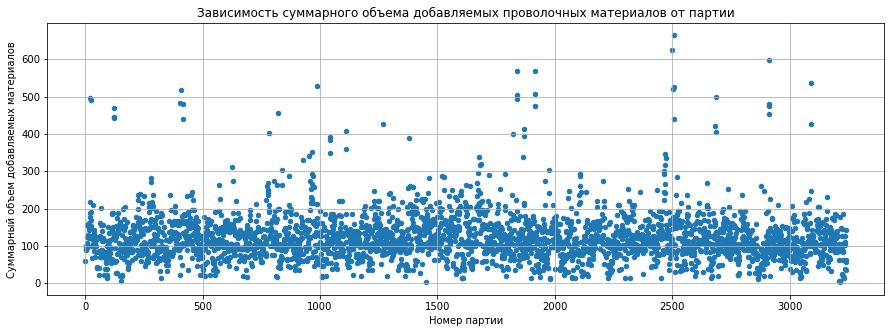

In [59]:
(data_wire.set_index('key').sum(axis=1, skipna=True).to_frame('wire_sum').reset_index()
 .plot(x='key', y='wire_sum', kind='scatter', figsize=(15, 5), grid=True)
 .set(title='Зависимость суммарного объема добавляемых проволочных материалов от партии',
     xlabel='Номер партии',
     ylabel='Суммарный объем добавляемых материалов'));

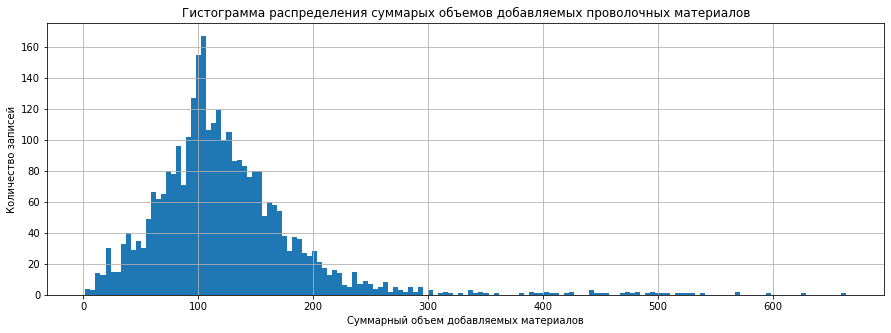

In [60]:
(data_wire.set_index('key').sum(axis=1, skipna=True).hist(bins=151, figsize=(15, 5))
          .set(title='Гистограмма распределения суммарых объемов добавляемых проволочных материалов',
               xlabel='Суммарный объем добавляемых материалов',
               ylabel='Количество записей'));

In [61]:
data_wire.set_index('key').sum(axis=1, skipna=True).describe()

count    3081.000000
mean      123.723326
std        66.082966
min         1.918800
25%        86.112000
50%       114.179523
75%       150.181198
max       663.851766
dtype: float64

Основная масса добавочного суммарного объема сосредоточена ниже 300, однако распределение имеет длинный "хвост" из-за чего среднее несколько выше медианы.

Оценим сколько проволочных компонентов добавляют сплав.

In [62]:
data_wire.set_index('key').notna().sum(axis=1).to_frame('wire_count').value_counts(normalize=True)

wire_count
1             0.628367
2             0.339176
3             0.028562
5             0.001947
4             0.001947
dtype: float64

В большинстве случаев в сплав добавляют один-два проволочных компонента. 

Аналогично сыпучим компонентам для проволочных компонентов удалим из таблицы колонки в которых данные заполнены лишь на 5% или меньше. Оставшиеся пропущенные значения заполним нулями и добавим столбец с числом вносимых материалов. 

In [63]:
data_wire = (data_wire.set_index('key').dropna(axis='columns', thresh=int(len(data_wire)*0.05)).fillna(0)
             .join(data_wire.set_index('key').notna().sum(axis=1).to_frame('wire_count')))

data_wire.head(10)

,Wire 1,Wire 2,wire_count
key,,,
1,60.059998,0.000000,1
2,96.052315,0.000000,1
3,91.160157,0.000000,1
4,89.063515,0.000000,1
5,89.238236,9.114560,2
6,99.109917,9.114560,2
7,98.061600,0.000000,1
8,155.282394,0.000000,1
9,113.393279,9.143681,2


In [64]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Wire 1      3081 non-null   float64
 1   Wire 2      3081 non-null   float64
 2   wire_count  3081 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 176.3 KB


Все столбцы в таблице data_wire заполнены. От использования таблицы data_wire_time пока откажемся.

<a id='section1.5'> </a>

### Данные о продувке сплава газом

In [65]:
data_gas = pd.read_csv(DATA_DIR + 'data_gas.csv')
data_gas.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [66]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Все данные в ячейках заполнены. Посмотрим на распределения.

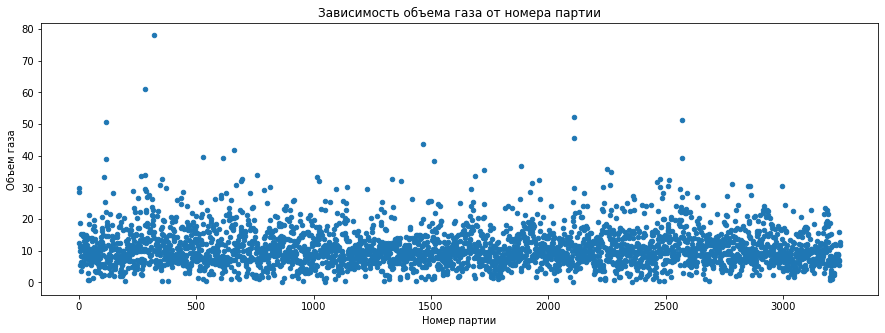

In [67]:
(data_gas.plot(x='key', y='Газ 1', kind='scatter', figsize=(15, 5))
         .set(title='Зависимость объема газа от номера партии',
              xlabel='Номер партии',
              ylabel='Объем газа'));

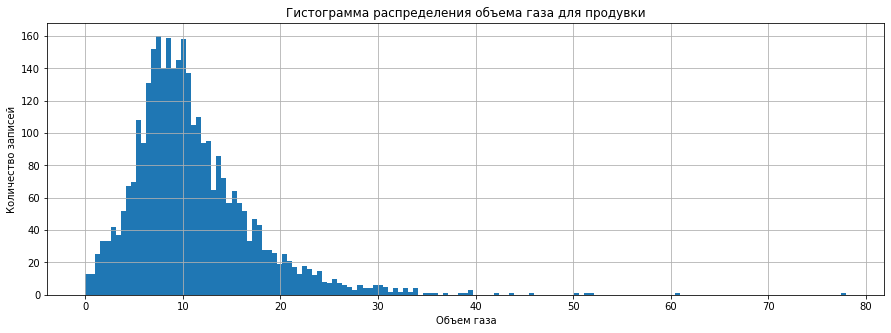

In [68]:
(data_gas['Газ 1'].hist(bins=151, figsize=(15, 5))
          .set(title='Гистограмма распределения объема газа для продувки',
               xlabel='Объем газа',
               ylabel='Количество записей'));

In [69]:
data_gas['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

Данные по газу омтавим без изменений, только сделаем индексацию по номеру партии.

In [70]:
data_gas = data_gas.set_index('key')
data_gas.head()

,Газ 1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


<a id='section2'> </a>

### Сбор датасета

Соберем все полученные нами таблицы в одну. Первой была получена сводная таблица по температуре. Переназовем столбцы в таблице

In [71]:
temp_groupby_key.columns = ['temp_' + x for x in temp_groupby_key.columns]

In [72]:
temp_groupby_key

,temp_count,temp_median,temp_mean,temp_std,temp_first,temp_last
key,,,,,,
1,5,1604.0,1601.400000,18.311199,1571.0,1613.0
2,6,1595.5,1593.500000,12.973049,1581.0,1602.0
3,5,1598.0,1597.800000,1.303840,1596.0,1599.0
4,3,1623.0,1616.333333,13.316656,1601.0,1625.0
5,2,1589.0,1589.000000,18.384776,1576.0,1602.0
...,...,...,...,...,...,...
2495,3,1590.0,1583.666667,11.846237,1570.0,1591.0
2496,4,1583.5,1579.000000,18.565200,1554.0,1591.0
2497,2,1580.0,1580.000000,12.727922,1571.0,1589.0


Поскольку по условиям можно использовать только начальную температуру, а промежуточные измерения нельзя, из таблицы возмем только столбцы temp_first и temp_last, причем temp_last является целевой переменной

In [73]:
df = temp_groupby_key[['temp_first', 'temp_last']]
df

,temp_first,temp_last
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


Присоединим второй полученный датафрейм, предварительно избавившись от мультииндекса.

In [74]:
arc_groupby_key.columns = [x  for x in arc_groupby_key.columns]

In [75]:
df = df.join(arc_groupby_key)
df.head(10)

,temp_first,temp_last,"(Активная мощность, count)","(Активная мощность, median)","(Активная мощность, sum)","(Реактивная мощность, sum)","(Время нагрева, c, median)","(Время нагрева, c, sum)"
key,,,,,,,,
1,1571.0,1613.0,5,0.805607,4.878147,1.571799,185.0,1098
2,1581.0,1602.0,4,0.659060,3.052598,1.257439,173.5,811
3,1596.0,1599.0,5,0.429355,2.525882,1.571799,109.0,655
4,1601.0,1625.0,4,0.781301,3.209250,1.257439,182.0,741
5,1576.0,1602.0,4,0.729026,3.347173,1.257439,191.5,869
6,1543.0,1596.0,4,0.983947,3.955108,1.257439,225.5,952
7,1586.0,1599.0,4,0.382923,2.547375,1.257439,108.5,673
8,1577.0,1598.0,4,0.883135,3.762755,1.257439,205.5,913
9,1587.0,1592.0,5,0.509361,2.081951,1.571799,156.0,625


Аналогично добавим данные по сыпучим/проволочным добавкам и газу.

In [76]:
df = df.join(data_bulk).join(data_wire).join(data_gas)

In [77]:
df.head(10)

,temp_first,temp_last,"(Активная мощность, count)","(Активная мощность, median)","(Активная мощность, sum)","(Реактивная мощность, sum)","(Время нагрева, c, median)","(Время нагрева, c, sum)",Bulk 1,Bulk 3,...,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,bulk_count,Wire 1,Wire 2,wire_count,Газ 1
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,5,0.805607,4.878147,1.571799,185.0,1098,0.0,0.0,...,0.0,0.0,206.0,150.0,154.0,4.0,60.059998,0.000000,1.0,29.749986
2,1581.0,1602.0,4,0.659060,3.052598,1.257439,173.5,811,0.0,0.0,...,0.0,0.0,206.0,149.0,154.0,4.0,96.052315,0.000000,1.0,12.555561
3,1596.0,1599.0,5,0.429355,2.525882,1.571799,109.0,655,0.0,0.0,...,0.0,0.0,205.0,152.0,153.0,4.0,91.160157,0.000000,1.0,28.554793
4,1601.0,1625.0,4,0.781301,3.209250,1.257439,182.0,741,0.0,0.0,...,0.0,0.0,207.0,153.0,154.0,4.0,89.063515,0.000000,1.0,18.841219
5,1576.0,1602.0,4,0.729026,3.347173,1.257439,191.5,869,0.0,0.0,...,0.0,0.0,203.0,151.0,152.0,4.0,89.238236,9.114560,2.0,5.413692
6,1543.0,1596.0,4,0.983947,3.955108,1.257439,225.5,952,0.0,0.0,...,0.0,0.0,204.0,201.0,154.0,4.0,99.109917,9.114560,2.0,11.273392
7,1586.0,1599.0,4,0.382923,2.547375,1.257439,108.5,673,0.0,0.0,...,0.0,0.0,204.0,152.0,154.0,4.0,98.061600,0.000000,1.0,9.836267
8,1577.0,1598.0,4,0.883135,3.762755,1.257439,205.5,913,0.0,0.0,...,0.0,0.0,410.0,252.0,153.0,4.0,155.282394,0.000000,1.0,15.171553
9,1587.0,1592.0,5,0.509361,2.081951,1.571799,156.0,625,0.0,0.0,...,0.0,0.0,107.0,99.0,203.0,4.0,113.393279,9.143681,2.0,8.216623


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   temp_first                   2475 non-null   float64
 1   temp_last                    2475 non-null   float64
 2   (Активная мощность, count)   2475 non-null   int64  
 3   (Активная мощность, median)  2475 non-null   float64
 4   (Активная мощность, sum)     2475 non-null   float64
 5   (Реактивная мощность, sum)   2475 non-null   float64
 6   (Время нагрева, c, median)   2475 non-null   float64
 7   (Время нагрева, c, sum)      2475 non-null   int64  
 8   Bulk 1                       2407 non-null   float64
 9   Bulk 3                       2407 non-null   float64
 10  Bulk 4                       2407 non-null   float64
 11  Bulk 6                       2407 non-null   float64
 12  Bulk 10                      2407 non-null   float64
 13  Bulk 11           

После объединения в данных появились пропуски в столбцах связанных с добавками. Очевидно, что есть такие партии в которых могут присутствовать отдельно только сыпучие или отдельно только проволочные добавки либо вообще отсутствовать добавки как таковые.

Заполним пропуски нулями, а так же вернем колонку с номером партии в столбцы, так как от номера партии зависит распределение температуры.

In [79]:
df = df.fillna(0).reset_index()
df.head()

,key,temp_first,temp_last,"(Активная мощность, count)","(Активная мощность, median)","(Активная мощность, sum)","(Реактивная мощность, sum)","(Время нагрева, c, median)","(Время нагрева, c, sum)",Bulk 1,...,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,bulk_count,Wire 1,Wire 2,wire_count,Газ 1
0,1,1571.0,1613.0,5,0.805607,4.878147,1.571799,185.0,1098,0.0,...,0.0,0.0,206.0,150.0,154.0,4.0,60.059998,0.00000,1.0,29.749986
1,2,1581.0,1602.0,4,0.659060,3.052598,1.257439,173.5,811,0.0,...,0.0,0.0,206.0,149.0,154.0,4.0,96.052315,0.00000,1.0,12.555561
2,3,1596.0,1599.0,5,0.429355,2.525882,1.571799,109.0,655,0.0,...,0.0,0.0,205.0,152.0,153.0,4.0,91.160157,0.00000,1.0,28.554793
3,4,1601.0,1625.0,4,0.781301,3.209250,1.257439,182.0,741,0.0,...,0.0,0.0,207.0,153.0,154.0,4.0,89.063515,0.00000,1.0,18.841219
4,5,1576.0,1602.0,4,0.729026,3.347173,1.257439,191.5,869,0.0,...,0.0,0.0,203.0,151.0,152.0,4.0,89.238236,9.11456,2.0,5.413692


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   key                          2475 non-null   int64  
 1   temp_first                   2475 non-null   float64
 2   temp_last                    2475 non-null   float64
 3   (Активная мощность, count)   2475 non-null   int64  
 4   (Активная мощность, median)  2475 non-null   float64
 5   (Активная мощность, sum)     2475 non-null   float64
 6   (Реактивная мощность, sum)   2475 non-null   float64
 7   (Время нагрева, c, median)   2475 non-null   float64
 8   (Время нагрева, c, sum)      2475 non-null   int64  
 9   Bulk 1                       2475 non-null   float64
 10  Bulk 3                       2475 non-null   float64
 11  Bulk 4                       2475 non-null   float64
 12  Bulk 6                       2475 non-null   float64
 13  Bulk 10           

Все пропуски заполнены. Последнее что надо сделать прежде чем идти дальше - провести замену типов т.к. двойная точность в данном случае изыточна. Выведем названия столбцов и их типы данных в виде словаря, а затем произведем замену типов данных по словарю.

In [81]:
df.dtypes.apply(lambda x: x.name).to_dict()

{'key': 'int64',
 'temp_first': 'float64',
 'temp_last': 'float64',
 ('Активная мощность', 'count'): 'int64',
 ('Активная мощность', 'median'): 'float64',
 ('Активная мощность', 'sum'): 'float64',
 ('Реактивная мощность', 'sum'): 'float64',
 ('Время нагрева, c', 'median'): 'float64',
 ('Время нагрева, c', 'sum'): 'int64',
 'Bulk 1': 'float64',
 'Bulk 3': 'float64',
 'Bulk 4': 'float64',
 'Bulk 6': 'float64',
 'Bulk 10': 'float64',
 'Bulk 11': 'float64',
 'Bulk 12': 'float64',
 'Bulk 14': 'float64',
 'Bulk 15': 'float64',
 'bulk_count': 'float64',
 'Wire 1': 'float64',
 'Wire 2': 'float64',
 'wire_count': 'float64',
 'Газ 1': 'float64'}

In [82]:
# заменим типы в таблице по словарю df_type_dict
df_type_dict = {'key': 'int32',
 'temp_first': 'float32',
 'temp_last': 'float32',
 ('Активная мощность', 'count'): 'uint8',
 ('Активная мощность', 'median'): 'float32',
 ('Активная мощность', 'sum'): 'float32',
 ('Реактивная мощность', 'sum'): 'float32',
 ('Время нагрева, c', 'median'): 'float32',
 ('Время нагрева, c', 'sum'): 'float32',
 'Bulk 1': 'float32',
 'Bulk 3': 'float32',
 'Bulk 4': 'float32',
 'Bulk 6': 'float32',
 'Bulk 10': 'float32',
 'Bulk 11': 'float32',
 'Bulk 12': 'float32',
 'Bulk 14': 'float32',
 'Bulk 15': 'float32',
 'bulk_count': 'uint8',
 'Wire 1': 'float32',
 'Wire 2': 'float32',
 'wire_count': 'uint8',
 'Газ 1': 'float32'}

df = df.astype(df_type_dict)

# убедимся что замена прошла так как задумано
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   key                          2475 non-null   int32  
 1   temp_first                   2475 non-null   float32
 2   temp_last                    2475 non-null   float32
 3   (Активная мощность, count)   2475 non-null   uint8  
 4   (Активная мощность, median)  2475 non-null   float32
 5   (Активная мощность, sum)     2475 non-null   float32
 6   (Реактивная мощность, sum)   2475 non-null   float32
 7   (Время нагрева, c, median)   2475 non-null   float32
 8   (Время нагрева, c, sum)      2475 non-null   float32
 9   Bulk 1                       2475 non-null   float32
 10  Bulk 3                       2475 non-null   float32
 11  Bulk 4                       2475 non-null   float32
 12  Bulk 6                       2475 non-null   float32
 13  Bulk 10           

Замена типов данных позволила сократить использование памяти более чем в два раза. Теперь можно переходить к обучению моделей.

<a id='section3'> </a>

## Обучение моделей

Прежде чем начать обучение моделей создадим пеменные x_col, y_col в которые сохраним названия признаков и целевую переменную, а так же разделим данные на обучающую и тестовую выборки


In [83]:
y_col = ['temp_last']
x_col = df.columns.drop(y_col)
x_col

Index([                          'key',                    'temp_first',
        ('Активная мощность', 'count'), ('Активная мощность', 'median'),
          ('Активная мощность', 'sum'),  ('Реактивная мощность', 'sum'),
        ('Время нагрева, c', 'median'),     ('Время нагрева, c', 'sum'),
                              'Bulk 1',                        'Bulk 3',
                              'Bulk 4',                        'Bulk 6',
                             'Bulk 10',                       'Bulk 11',
                             'Bulk 12',                       'Bulk 14',
                             'Bulk 15',                    'bulk_count',
                              'Wire 1',                        'Wire 2',
                          'wire_count',                         'Газ 1'],
      dtype='object')

In [84]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

Проверим размеры выборок.

In [85]:
len(train)

1980

In [86]:
len(test)

495

In [87]:
len(train) + len(test) == len(df)

True

Отмасштабируем признаки.

In [88]:
scaler = StandardScaler()
scaler.fit(train[x_col])
train_scaled = train.copy()
train_scaled[x_col] = scaler.transform(train[x_col])
train_scaled.head()

,key,temp_first,temp_last,"(Активная мощность, count)","(Активная мощность, median)","(Активная мощность, sum)","(Реактивная мощность, sum)","(Время нагрева, c, median)","(Время нагрева, c, sum)",Bulk 1,...,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,bulk_count,Wire 1,Wire 2,wire_count,Газ 1
2090,1.190830,1.191296,1556.0,1.471855,-0.877263,0.029791,1.471855,-0.713111,0.039915,2.496178,...,-0.232549,-0.183672,-1.277922,-1.761144,-1.299788,1.135872,-1.889175,-0.507569,4.254826,1.026649
1451,0.302791,1.071984,1599.0,-0.396269,-0.986095,-0.996657,-0.396269,-1.068224,-1.031232,-0.268683,...,-0.232549,-0.183672,0.005537,0.621429,1.063091,0.396547,0.468014,-0.507569,-0.537299,-0.245658
2137,1.255943,-0.717702,1593.0,-0.396269,0.260457,-0.301541,-0.396269,0.093963,-0.458773,-0.268683,...,4.713226,-0.183672,0.024504,-0.223622,-0.095183,0.396547,-1.014702,-0.507569,-0.537299,-0.485574
969,-0.369126,0.674276,1593.0,-1.018977,-0.917938,-1.309901,-1.018977,-0.799199,-1.308609,-0.268683,...,-0.232549,-0.183672,-1.277922,-1.761144,-1.299788,-2.560753,0.823874,-0.507569,-0.537299,-1.111173
1325,0.126846,-1.672201,1596.0,1.471855,0.857040,2.100723,1.471855,0.642773,2.185161,-0.268683,...,-0.232549,-0.183672,1.320608,0.668376,1.121005,0.396547,1.300629,-0.507569,-0.537299,0.225248


In [89]:
test_scaled = test.copy()
test_scaled[x_col] = scaler.transform(test[x_col])

### Линейная регрессия

In [90]:
linear_regression_model = LinearRegression()
linear_regression_scores = cross_val_score(linear_regression_model, train_scaled[x_col], train_scaled[y_col].values.ravel(), 
                                           cv=5, scoring = 'neg_mean_absolute_error', n_jobs=-1)
linear_regression_scores

array([-7.72096685, -7.08423299, -7.53933627, -7.36020729, -7.46540387])

In [91]:
print("Модель показывает MAE: %0.4f. СКО оценки при этом: %0.4f" % (-linear_regression_scores.mean(), 
                                                                    linear_regression_scores.std()))

Модель показывает MAE: 7.4340. СКО оценки при этом: 0.2108


### Случайный лес

In [92]:
# # ниже представлен код который переберает число деревьев и их глубину и ищет наилучшую модель по заданному критерию
# # так как перебор занимает порядка 30 минут код закомментирован.  
# # модель с уже найдеными лучшими параметрами представлена в следующей ячейке

# best_forest_depth = 1
# best_forest_n_estimators = 1
# best_forest_mean_score = 100
# best_forest_std_score = 0
# for n_estimators in tqdm(range(1, 151, 1)):
#     for depth in range(1, 16, 1):
#         random_forest_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=depth, random_state=42, n_jobs=-1)
#         scores = cross_val_score(random_forest_model, train_scaled[x_col], train_scaled[y_col].values.ravel(), cv=5, 
#                                  scoring='neg_mean_absolute_error', n_jobs=-1)
#         if -scores.mean() < best_forest_mean_score:
#             best_forest_depth = depth
#             best_forest_n_estimators = n_estimators
#             best_forest_mean_score = -scores.mean()
#             best_forest_std_score = scores.std()

# print("Модель показывает MAE: %0.4f. СКО оценки при этом: %0.4f" % (best_forest_mean_score, best_forest_std_score))
# print('Число деревьев:', best_forest_n_estimators)
# print('Глубина деревьев %0.4f' % (best_forest_depth))

In [93]:
best_random_forest_model = RandomForestRegressor(n_estimators=108, max_depth=14, random_state=42, n_jobs=-1)
random_forest_scores = cross_val_score(best_random_forest_model, train_scaled[x_col], train_scaled[y_col].values.ravel(), 
                                       cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

print("Модель показывает MAE: %0.4f. СКО оценки при этом: %0.4f" % (-random_forest_scores.mean(), 
                                                                    random_forest_scores.std()))

Модель показывает MAE: 6.2759. СКО оценки при этом: 0.2935


### CatBoost

In [94]:
cv_pool = Pool(train_scaled[x_col], train_scaled[y_col].values.ravel())

params = {"learning_rate": 0.02,
          "iterations": 9874,
          "depth": 3,
          "loss_function": "MAE",
          "eval_metric": "MAE",
          "l2_leaf_reg": 30.0,
          "bootstrap_type": "Bayesian",
          "random_state": 42,
          "verbose": False}

cb_scores = cv(cv_pool, params, fold_count=5, verbose=1000)

0:	learn: 1563.5091108	test: 1563.5091916	best: 1563.5091916 (0)
1000:	learn: 5.2302526	test: 6.1855835	best: 6.1855835 (1000)
2000:	learn: 4.6649107	test: 6.0547321	best: 6.0547321 (2000)
3000:	learn: 4.3396105	test: 6.0172685	best: 6.0172095 (2989)
4000:	learn: 4.1049568	test: 6.0053435	best: 6.0049667 (3992)
5000:	learn: 3.9284677	test: 5.9925050	best: 5.9925050 (5000)
6000:	learn: 3.7882834	test: 5.9888385	best: 5.9882671 (5961)
7000:	learn: 3.6736199	test: 5.9891056	best: 5.9880848 (6360)
8000:	learn: 3.5755048	test: 5.9892108	best: 5.9876683 (7353)
9000:	learn: 3.4902147	test: 5.9852881	best: 5.9846714 (8991)
9873:	learn: 3.4260029	test: 5.9836079	best: 5.9836079 (9873)	total: 1m 39s	remaining: 0us


In [95]:
cb_scores.tail()

,iterations,test-MAE-mean,test-MAE-std,train-MAE-mean,train-MAE-std
9869,9869,5.983618,0.145719,3.426401,0.037341
9870,9870,5.983681,0.145671,3.426265,0.037296
9871,9871,5.983672,0.145702,3.426149,0.037235
9872,9872,5.983678,0.145685,3.426086,0.037286
9873,9873,5.983608,0.145778,3.426003,0.037283


### VotingRegressor

In [96]:
# # ниже представлен код который переберает веса моделей и ищет наилучший голосующий классификатор по заданному критерию
# # так как перебор весов занимает порядка 12 мин код закомментирован.  
# # модель с уже найдеными весами представлена в следующей ячейке

# best_weights = []
# best_mean_score = 100

# for w0 in tqdm(np.arange(0, 1.1, 0.1)):
#     w1 = 1 - w0
#     voiting_regressor = VotingRegressor(estimators=[('cb', CatBoostRegressor(**params)),
#                                                     ('rf', best_random_forest_model)],
#                                         weights=[w0, w1], n_jobs=-1)
    
#     score = cross_val_score(voiting_regressor, train_scaled[x_col], train_scaled[y_col].values.ravel(), 
#                             cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
#     if -score.mean() < best_mean_score:
#         best_mean_score = -score.mean()
#         best_weights = [w0, w1]

# best_weights, best_mean_score

In [97]:
voiting_regressor = VotingRegressor(estimators=[('cb', CatBoostRegressor(**params)),
                                                ('rf', best_random_forest_model)],
                                        weights=[0.8, 0.2], n_jobs=-1)

voiting_regressor_score = cross_val_score(voiting_regressor, train_scaled[x_col], train_scaled[y_col].values.ravel(), 
                                          cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
print("Модель показывает MAE: %0.4f. СКО оценки при этом: %0.4f" % (-voiting_regressor_score.mean(), 
                                                                    voiting_regressor_score.std()))

Модель показывает MAE: 5.9283. СКО оценки при этом: 0.2079


<a id='section4'> </a>

## Тестирование моделей

Прежде чем переходить к тестированию моделей, создадим модель которая будеть всегда предсказывать медианную температуру и оценим ее качество.

In [98]:
dummy_model = DummyRegressor(strategy='median')
dummy_scores = cross_val_score(dummy_model, train_scaled[x_col], train_scaled[y_col], 
                               cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
print("Модель показывает MAE: %0.4f. СКО оценки при этом: %0.4f" % (-dummy_scores.mean(), 
                                                                    dummy_scores.std()))

Модель показывает MAE: 10.0056. СКО оценки при этом: 0.4471


Создадим словарь со всеми рассмотренными моделями и оценим качество моделей на тестовой выборке.

In [99]:
models_dict = {'Dummy Regressor': dummy_model,
               'Linear Regression': linear_regression_model,
               'Random Forest': best_random_forest_model,
               'CatBoost': CatBoostRegressor(**params),
               'Voting Regressor': voiting_regressor
              }

In [100]:
models_test_score = []

for name, model in models_dict.items():
    model.fit(train_scaled[x_col], train_scaled[y_col].values.ravel())
    score = mean_absolute_error(test_scaled[y_col], model.predict(test_scaled[x_col]))
    models_test_score.append(score)
    print(name, 'на тестовой выборке показывает MAE: %0.4f' % score)

Dummy Regressor на тестовой выборке показывает MAE: 9.4566
Linear Regression на тестовой выборке показывает MAE: 7.4280
Random Forest на тестовой выборке показывает MAE: 5.7026
CatBoost на тестовой выборке показывает MAE: 5.5619
Voting Regressor на тестовой выборке показывает MAE: 5.4937


Посмотрим на важность признаков в модели CatBoost.

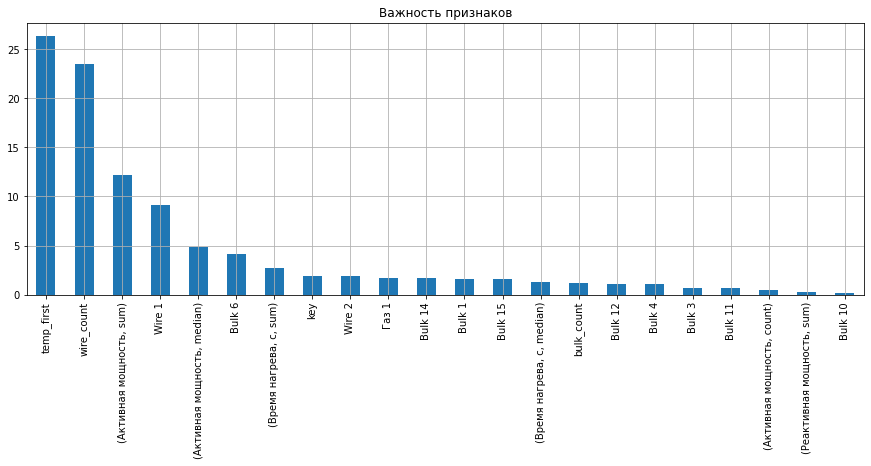

In [101]:
(pd.Series(models_dict['CatBoost'].get_feature_importance(), index=x_col)
 .sort_values(ascending=False)
 .plot(kind='bar', figsize=(15,5), grid=True)
 .set(title='Важность признаков'));

_________

Сведем все полученные оценки качества моделей в одну таблицу.

In [102]:
result = pd.DataFrame({'Model': [x for x in models_dict],
                       'Test MAE': models_test_score,
                       'CV MAE Mean (5 Folds)': [-dummy_scores.mean(), -linear_regression_scores.mean(), 
                                                 -random_forest_scores.mean(), cb_scores.iloc[-1, 1], 
                                                 -voiting_regressor_score.mean()],
                       'CV MAE Std (5 Folds)': [dummy_scores.std(), linear_regression_scores.std(), 
                                                random_forest_scores.std(), cb_scores.iloc[-1, 2], 
                                                voiting_regressor_score.std()]
                     })

result.set_index('Model').sort_values('Test MAE')

,Test MAE,CV MAE Mean (5 Folds),CV MAE Std (5 Folds)
Model,,,
Voting Regressor,5.493717,5.928291,0.207856
CatBoost,5.561886,5.983608,0.145778
Random Forest,5.702574,6.275934,0.293498
Linear Regression,7.427980,7.434029,0.210815
Dummy Regressor,9.456566,10.005556,0.447086


Наилучшие результаты как на кросвалидации так и на тестовой выборке показывает голосующая модель. Близкие результаты показывает модель CatBoost, так же модель бустинга получилась чуть более робастной (меньше разброс оценок на кросвалидации). Все рассмотренные модели показывают результат лучше чем константное предсказание температуры медианой.

<a id='section5'> </a>

## Выводы

В процессе исследования были проведены следующие работы:
1. Исследовательский анализ данных (о температуре, электродах, подаче сыпучих и проволочных материалов, продувке газом).
2. Подготовка данных (удаление выбросов, заполнение пропусков, объединение таблиц и т.д.).
3. Обучение моделей:
    * Linear Regression;
    * Random Forest;
    * CatBoost;
    * Voting Regressor (Random Forest + CatBoost).
4. Анализ качества обученных моделей.
    
Наилучшие показатели по критерию минимума абсолютной ошибки на тестовой выборке показала модель Voting Regressor (MAE 5,49 градуса). Блзкие результаты на тестовой выборке показали модели Random Forest и CatBoost (5,70 и 5,56 градуса соответственно). Однако модель CatBoost оказалась наиболее робастной из всех рассмотренных (СКО MAE на кросвалидации 0,15 градуса).


Для дальнейшей работы рекомендуется рассмотреть возможность использования CatBoost или голосующей модели.